# Trabajo Práctico 1: Análisis Exploratorio - Organización de Datos

**Alumnos y Padrón**
+ Craviotto Roitbarg, Mateo Exequiel - 106255 
+ Gómez, Joaquín - 103735

https://github.com/joaqogomez/Organizacion-de-datos-fiuba


## Introducción

En el presente trabajo se propone realizar un análisis de los datos recolectados por una agencia sobre las personas que pagan los impuestos.
El objetivo de la agencia es utilizar la información recolectada para dirigir campañas y poder dirigir a los fiuagentes recaudadores a inspeccionar.


## Objetivos
Los objetivos de este notebook es:
- Entender los datos.
- Ver como se relacionan entre si.
- Poder sacar alguna conclusión o descubrir un patrón.
- Indicar cuáles son los factores más importantes que determinan si una persona tiene altos o bajos ingresos. 
- Armar un baseline.

## Configuraciones Iniciales
Primero, importamos las bibliotecas que vamos a utilizar:

In [26]:
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns

## Carga del set de datos
Cargamos el dataset:

In [27]:
with requests.get(
    "https://docs.google.com/spreadsheets/d/1-DWTP8uwVS-dZY402-dm0F9ICw_6PNqDGLmH0u8Eqa0/export?format=csv"
) as r, open("Dataset/impuestos.csv", "wb") as f:
    for chunk in r.iter_content():
        f.write(chunk)
df = pd.read_csv("Dataset/impuestos.csv")

## Limpieza del set de datos

Despues de cargar el dataset, chequeamos que campos tenemos y si tienen valores NULL.

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 13 columns):
 #   Column                                      Non-Null Count  Dtype 
---  ------                                      --------------  ----- 
 0   anios_estudiados                            32561 non-null  int64 
 1   barrio                                      31978 non-null  object
 2   categoria_de_trabajo                        30725 non-null  object
 3   edad                                        32561 non-null  int64 
 4   educacion_alcanzada                         32561 non-null  object
 5   estado_marital                              32561 non-null  object
 6   ganancia_perdida_declarada_bolsa_argentina  32561 non-null  int64 
 7   genero                                      32561 non-null  object
 8   horas_trabajo_registradas                   32561 non-null  int64 
 9   religion                                    32561 non-null  object
 10  rol_familiar_registrad

Se observa que tenemos valores null en las columnas barrio, categoria_de_trabajo y trabajo.

Convierto las variables de tipo object en variables de tipo category:

In [29]:
#Verificamos que nuestra variable target, en este caso tiene_alto_valor_adquisitivo no tenga valores invalidos
df.tiene_alto_valor_adquisitivo.value_counts()
#Se puede ver que solo tiene dos valores disponibles que son 0 y 1 como necesitamos

0    24720
1     7841
Name: tiene_alto_valor_adquisitivo, dtype: int64

In [30]:
df.trabajo.value_counts()

profesional_especializado    4140
reparador                    4099
directivo_gerente            4066
entretenimiento              3770
ventas                       3650
otros                        3295
inspector                    2002
transporte                   1597
limpiador                    1370
sector_primario               994
soporte_tecnico               928
seguridad                     649
servicio_domestico            149
ejercito                        9
Name: trabajo, dtype: int64

In [31]:
df.categoria_de_trabajo.value_counts()

relacion_de_dependencia    22696
monotibutista               2541
empleado_municipal          2093
empleado_provincial         1298
responsable_inscripto       1116
empleadao_estatal            960
trabajo_voluntariado          14
sin_trabajo                    7
Name: categoria_de_trabajo, dtype: int64

In [32]:
df.barrio.value_counts()

Palermo                29170
Belgrano                 643
San Isidro               198
Villa Urquiza            137
Recoleta                 121
La Boca                  114
Agronomia                106
Almagro                  100
Balvanera                 95
Puerto Madero             90
Caballito                 81
Boedo                     80
Barracas                  75
Chacarita                 73
Coghland                  70
Floresta                  67
Constitucion              64
Colegiales                62
Flores                    60
Liniers                   59
Monte Castro              51
Mataderos                 44
Nueva Pompeya             43
Monserrat                 37
nuñez                     34
Parque Chacabuco          31
Parque Avellaneda         29
Villa Luro                29
Parque Chas               28
La Paternal               24
Retiro                    20
Villa Soldati             19
Villa Devoto              19
San Telmo                 18
Villa Real    

In [33]:
df.educacion_alcanzada.value_counts()


4_anio                10501
5_anio                 7291
universidad_3_anio     5355
universidad_4_anio     1723
universidad_1_anio     1382
2_anio                 1175
universidad_2_anio     1067
1_anio                  933
7-8_grado               646
universiada_5_anio      576
9_grado                 514
3_anio                  433
universiada_6_anio      413
5-6_grado               333
1-4_grado               168
preescolar               51
Name: educacion_alcanzada, dtype: int64

In [34]:
df[df['barrio'].isna() & df['trabajo'].isna() &df['tiene_alto_valor_adquisitivo'] == 1]

,anios_estudiados,barrio,categoria_de_trabajo,edad,educacion_alcanzada,estado_marital,ganancia_perdida_declarada_bolsa_argentina,genero,horas_trabajo_registradas,religion,rol_familiar_registrado,tiene_alto_valor_adquisitivo,trabajo
1676,13,NaN,NaN,64,4_anio,matrimonio_civil,0,hombre,40,cristianismo,casado,1,NaN
18615,17,NaN,NaN,27,universidad_3_anio,matrimonio_civil,0,mujer,35,judaismo,casada,1,NaN
25359,17,NaN,NaN,38,universidad_3_anio,matrimonio_civil,7688,mujer,50,otro,casada,1,NaN
26363,14,NaN,NaN,48,5_anio,matrimonio_civil,0,hombre,40,cristianismo,casado,1,NaN


In [35]:
df[(df['ganancia_perdida_declarada_bolsa_argentina'] != 0) & df['categoria_de_trabajo'].isna()]


,anios_estudiados,barrio,categoria_de_trabajo,edad,educacion_alcanzada,estado_marital,ganancia_perdida_declarada_bolsa_argentina,genero,horas_trabajo_registradas,religion,rol_familiar_registrado,tiene_alto_valor_adquisitivo,trabajo
106,10,Palermo,NaN,17,1_anio,sin_matrimonio,34095,mujer,32,cristianismo,con_hijos,0,NaN
297,18,NaN,NaN,39,universidad_4_anio,matrimonio_civil,3464,mujer,40,budismo,casada,0,NaN
408,14,Palermo,NaN,28,5_anio,matrimonio_civil,-1887,mujer,40,cristianismo,casada,1,NaN
484,12,Palermo,NaN,52,3_anio,sin_matrimonio,594,hombre,40,judaismo,otro,0,NaN
656,9,Palermo,NaN,70,9_grado,viudo_a,1111,mujer,15,cristianismo,soltero_a,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30628,17,Palermo,NaN,65,universidad_3_anio,matrimonio_civil,5556,hombre,48,cristianismo,casado,1,NaN
30781,14,Palermo,NaN,66,5_anio,viudo_a,-4356,mujer,40,judaismo,soltero_a,0,NaN
31062,13,Palermo,NaN,59,4_anio,matrimonio_civil,2407,hombre,60,cristianismo,casado,0,NaN
31605,12,Palermo,NaN,20,3_anio,sin_matrimonio,-1602,hombre,40,otro,sin_familia,0,NaN


Observemos la cantidad de valores nulos para cada feature. Hay valores nulos en las columas 'barrio', 'categoria_de_trabajo' y 'trabajo'.

In [36]:
df.isnull().sum()

anios_estudiados                                 0
barrio                                         583
categoria_de_trabajo                          1836
edad                                             0
educacion_alcanzada                              0
estado_marital                                   0
ganancia_perdida_declarada_bolsa_argentina       0
genero                                           0
horas_trabajo_registradas                        0
religion                                         0
rol_familiar_registrado                          0
tiene_alto_valor_adquisitivo                     0
trabajo                                       1843
dtype: int64

Y estos serían los porcentajes de valores nulos para cada feature:

In [37]:
(df.isnull().mean() * 100).to_frame('porcentaje nulls')

,porcentaje nulls
anios_estudiados,0.000000
barrio,1.790486
categoria_de_trabajo,5.638647
edad,0.000000
educacion_alcanzada,0.000000
estado_marital,0.000000
ganancia_perdida_declarada_bolsa_argentina,0.000000
genero,0.000000
horas_trabajo_registradas,0.000000
religion,0.000000


Si hacemos un análisis de los valores nulos en las columnas categoría de trabajo y trabajo, podemos encontrar una relación entre estas

In [38]:
trabajo_y_categoria_na = df[df['categoria_de_trabajo'].isna() & df['trabajo'].isna()]
print(f"Hay {len(trabajo_y_categoria_na)} filas con valores nulos en trabajo y categoría")

# Hay 1836 filas que tienen NaN en ambas categorías.

sin_trabajo = df[df['categoria_de_trabajo'] == 'sin_trabajo']
sin_trabajo[['categoria_de_trabajo', 'trabajo']]

Hay 1836 filas con valores nulos en trabajo y categoría


,categoria_de_trabajo,trabajo
5361,sin_trabajo,NaN
10845,sin_trabajo,NaN
14772,sin_trabajo,NaN
20337,sin_trabajo,NaN
23232,sin_trabajo,NaN
32304,sin_trabajo,NaN
32314,sin_trabajo,NaN


Eliminamos los que tienen categoria_de_trabajo y trabajo NaN.

In [39]:
df = df.dropna(subset=['categoria_de_trabajo'])
df.isnull().sum()

anios_estudiados                                0
barrio                                        556
categoria_de_trabajo                            0
edad                                            0
educacion_alcanzada                             0
estado_marital                                  0
ganancia_perdida_declarada_bolsa_argentina      0
genero                                          0
horas_trabajo_registradas                       0
religion                                        0
rol_familiar_registrado                         0
tiene_alto_valor_adquisitivo                    0
trabajo                                         7
dtype: int64

Reemplazamos los NaN de la categoría barrio con una categoría llamamda 'No responde'.


In [40]:
df = df.replace(np.nan, {'trabajo': 'desempleado', 'barrio': 'No responde'})
df.reset_index(drop=True, inplace=True)
df.isnull().sum()

anios_estudiados                              0
barrio                                        0
categoria_de_trabajo                          0
edad                                          0
educacion_alcanzada                           0
estado_marital                                0
ganancia_perdida_declarada_bolsa_argentina    0
genero                                        0
horas_trabajo_registradas                     0
religion                                      0
rol_familiar_registrado                       0
tiene_alto_valor_adquisitivo                  0
trabajo                                       0
dtype: int64

In [44]:
def definir_nivel(nivel):
    if nivel.startswith("uni"):
        return "universitario"
    elif nivel.endswith("anio"):
        return "secundario"
    elif nivel.endswith("grado"):
        return "primario"
    else:
        return "jardin"

df['nivel_educativo_alcanzado'] = df['educacion_alcanzada'].apply(definir_nivel)

In [45]:
df.nivel_educativo_alcanzado.value_counts()

secundario       19029
universitario    10154
primario          1496
jardin              46
Name: nivel_educativo_alcanzado, dtype: int64

In [46]:
# Cantidad con alto valor adquisitivo según nivel educativo alcanzado (jardín es 0)
con_alto_valor_adquisitivo = df[df['tiene_alto_valor_adquisitivo'] == 1]
con_alto_valor_adquisitivo.nivel_educativo_alcanzado.value_counts()

universitario    4434
secundario       3132
primario           84
Name: nivel_educativo_alcanzado, dtype: int64

Vamos a revisar que las columnas no numéricas que deberían contener solo caracteres, contengan lo que deberían contener. Obviamos la columna educacion_alcanzada, ya que esta puede tener números, y la columna recientemente agregada, nivel_educativo_alcanzado.

In [47]:
columnas_no_numericas = ['barrio', 'categoria_de_trabajo', 'estado_marital', 'genero', 'religion', 'rol_familiar_registrado', 'trabajo']
for c in columnas_no_numericas:
    print(df[c].str.contains('1|2|3|4|5|6|7|8|9|0|-|#|%|&|!|@').any())      

False
False
False
False
False
False
False


## Análisis de los datos

Para hacer el análisis del set de datos, primero vamos a realizarnos unas preguntas simples a modo de guía, para hacer un desarrollo a partir de estas. Las preguntas que surgieron en este caso son:

- ¿Está el barrio en el que residen las personas relacionado con sus ingresos?
- ¿Existe alguna relacion entre el género de una persona y sus ingresos?
- ¿En qué afecta el nivel de educación alcanzada?
- ¿Es directamente proporcional la cantidad de horas trabajadas con el valor adquisitivo de la gente?
- ¿Se debería tener en cuenta la religión?
- ¿Es el tipo de trabajo un factor fundamental para determinar los ingresos de una persona?
- ¿El rol familiar se debería tener en cuenta para la variable objetivo?
- ¿Si un contribuyente declara ganancia/pérdida en la bolsa, afecta esto fuertemente sus ingresos?
- ¿Se divide el valor adquisitivo en grupos etarios?


### ¿Hay relación entre el barrio y los ingresos?

Comencemos observando la distribución de los distintos barrios en el dataset.

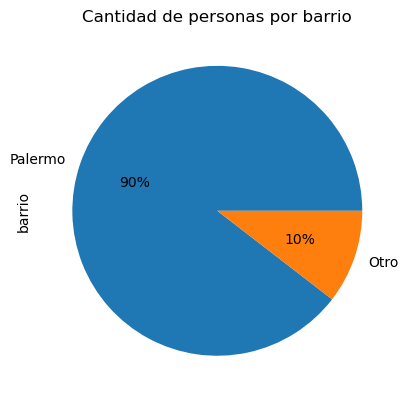

In [48]:
def cambiar_barrio(barrio):
    if barrio == "Palermo":
        return "Palermo"
    else:
        return "Otro"

df_para_grafico_barrio = df.copy()
df_para_grafico_barrio.barrio.value_counts()
df_para_grafico_barrio['barrio'] = df['barrio'].apply(cambiar_barrio)


plt.figure(figsize=(6.4, 4.8), dpi=100)
df_para_grafico_barrio['barrio'].value_counts().iloc[:4].plot(kind='pie', autopct='%1.0f%%')
plt.title('Cantidad de personas por barrio')
plt.show()

Se puede observar claramente que el barrio predominante es Palermo, el resto fueron agrupados porque su porcentaje es muy bajo.

## ¿Existe alguna relacion entre el género de una persona y sus ingresos?

Comenzamos primero por analizar como se distribuye el género en nuestro dataset

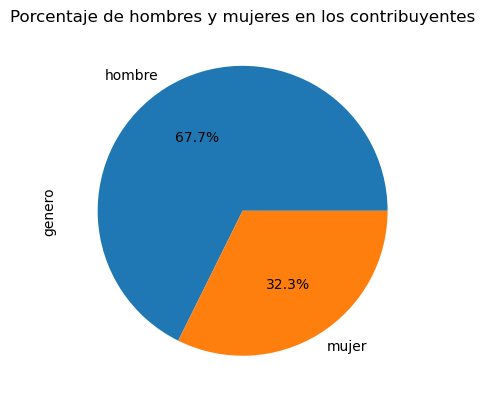

In [49]:
plt.figure(figsize=(6.4, 4.8), dpi=100)
df['genero'].value_counts().plot(kind='pie', autopct='%.01f%%')
plt.title('Porcentaje de hombres y mujeres en los contribuyentes')
plt.show()

El gráfico nos muestra que 2/3 de las personas en nuestro dataset son hombres.

A continuación, nos fijamos como se distribuye el género entre las personas que poseen altos ingresos:


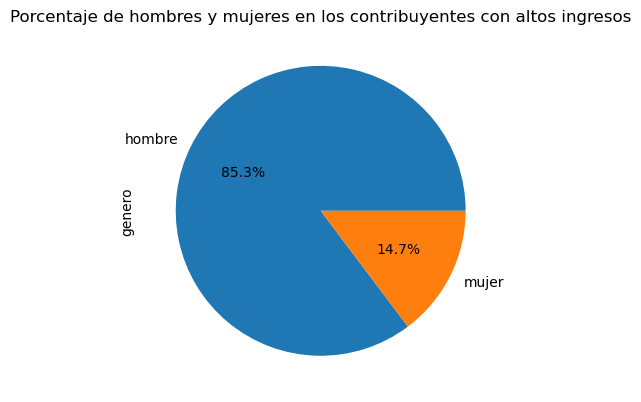

In [50]:
plt.figure(figsize=(6.4, 4.8), dpi=100)
df[df['tiene_alto_valor_adquisitivo'] == 1].genero.value_counts().plot(kind='pie', autopct='%.01f%%')
plt.title('Porcentaje de hombres y mujeres en los contribuyentes con altos ingresos')
plt.show()

Luego, nos fijamos como se distribuye el género entre las personas que poseen bajos ingresos:


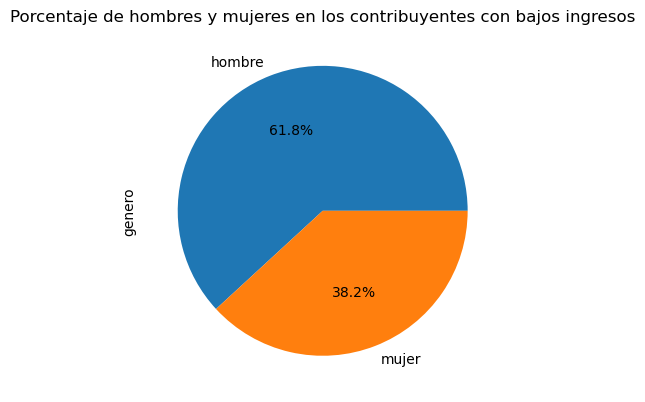

In [51]:
plt.figure(figsize=(6.4, 4.8), dpi=100)
df[df['tiene_alto_valor_adquisitivo'] == 0].genero.value_counts().plot(kind='pie', autopct='%.01f%%')
plt.title('Porcentaje de hombres y mujeres en los contribuyentes con bajos ingresos')
plt.show()

Observados estos gráficos, consideramos que el género no afecta en los ingresos de la persona.
Lo único que podemos afirmar es que si tenemos alguien de altos ingresos, existe una probabilidad muy alta de que sea una persona de género masculino.

## ¿En qué afecta el nivel de educación alcanzada?

Para ver esta relación, decidimos primero ver como se distribuyen los niveles de educacion alcanzada entre todas las personas:

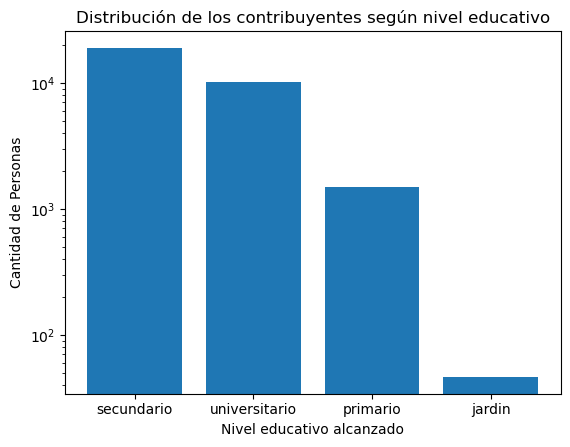

In [84]:
plt.figure(figsize=(6.4, 4.8), dpi=100)
personas_por_nivel_educativo = (df['nivel_educativo_alcanzado'].value_counts().sort_values(ascending=False))
plt.bar(personas_por_nivel_educativo.index, personas_por_nivel_educativo.values)
plt.yscale("log")
plt.ylabel("Cantidad de personas")
plt.xlabel("Nivel educativo alcanzado")
plt.title("Distribución de los contribuyentes según nivel educativo")
plt.show()

Como se puede ver, la mayoría de los contribuyentes alcanzaron una educación de nivel secundario y universitario.
A continuación, vamos a analizar el nivel educativo de las personas con altos ingresos.

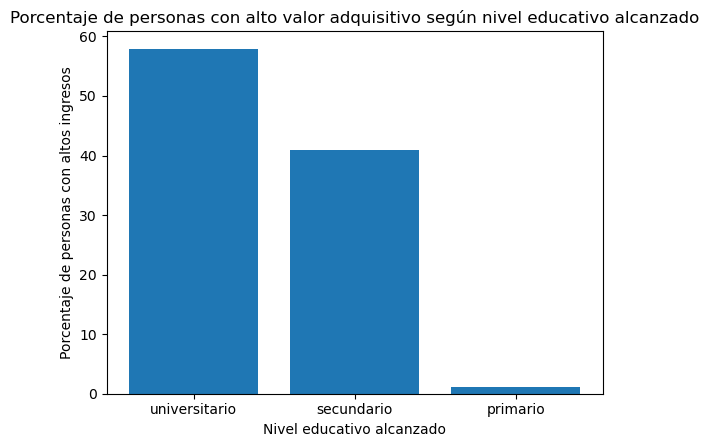

In [167]:
personas_con_alto_valor_adquisitivo = df[df['tiene_alto_valor_adquisitivo'] == 1]

porcentaje_alto_valor_adquisitivo = (
    personas_con_alto_valor_adquisitivo.nivel_educativo_alcanzado.value_counts() / 
    len(personas_con_alto_valor_adquisitivo) * 100
)
plt.figure(figsize=(6.4, 4.8), dpi=100)
plt.ylabel("Porcentaje de personas con altos ingresos")
plt.xlabel("Nivel educativo alcanzado")
plt.title("Porcentaje de personas con alto valor adquisitivo según nivel educativo alcanzado")
plt.bar(porcentaje_alto_valor_adquisitivo.index, porcentaje_alto_valor_adquisitivo.values)
plt.show()

Como podemos observar, el porcentaje de personas con altos ingresos es mayor, cuanto mayor es el nivel educativo alcanzado. Como tenemos un gran porcentaje en secundario, decidimos ver si existe tal relación dentro de esa categoría. No revisamos la categoría universitarios ya que el nivel más alto que se puede alcanzar.

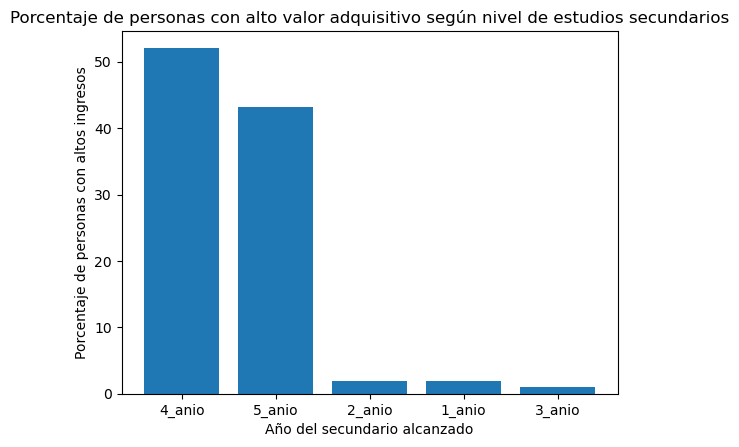

In [170]:
personas_con_alto_valor_adquisitivo = df[(df['tiene_alto_valor_adquisitivo'] == 1) & (df['nivel_educativo_alcanzado'] == "secundario")]

porcentaje_alto_valor_adquisitivo = (
    personas_con_alto_valor_adquisitivo.educacion_alcanzada.value_counts() / 
    len(personas_con_alto_valor_adquisitivo) * 100
)
plt.figure(figsize=(6.4, 4.8), dpi=100)
plt.ylabel("Porcentaje de personas con altos ingresos")
plt.xlabel("Año del secundario alcanzado")
plt.title("Porcentaje de personas con alto valor adquisitivo según nivel de estudios secundarios")
plt.bar(porcentaje_alto_valor_adquisitivo.index, porcentaje_alto_valor_adquisitivo.values)
plt.show()

Se puede ver que los contribuyentes con nivel educativo secundario que poseen altos ingresos pertenecen casi en su totalidad a los dos últimos años del secundario.

Por lo tanto, consideramos ideal dividir el nivel educativo en general en dos categorías llamadas "nivel superior" y "nivel inferior". De esta forma, al segmentar en dos grupos, es más fácil hacer el análisis de relación de  la educación con el valor adquisitivo de los contribuyentes. 

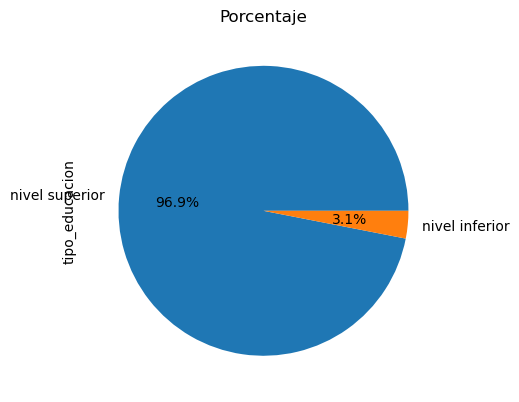

nivel superior    7415
nivel inferior     235
Name: tipo_educacion, dtype: int64

In [179]:
def determinar_nivel_educativo(educacion_alcanzada):
    if educacion_alcanzada.startswith("uni"):
        return "nivel superior"
    elif (educacion_alcanzada == "4_anio") | (educacion_alcanzada == "5_anio"):
        return "nivel superior"
    else:
        return "nivel inferior"
    
df['tipo_educacion'] = df['educacion_alcanzada'].apply(determinar_nivel_educativo)

personas_con_alto_valor_adquisitivo = df[df['tiene_alto_valor_adquisitivo'] == 1]
plt.figure(figsize=(6.4, 4.8), dpi=100)
personas_con_alto_valor_adquisitivo.tipo_educacion.value_counts().plot(kind='pie', autopct='%.01f%%')
plt.title('Porcentaje')
plt.show()
personas_con_alto_valor_adquisitivo.tipo_educacion.value_counts()

Podemos afirmar que, si se trata de una persona de lo que consideramos "nivel superior" (es decir, su máximo nivel educativo alcanzado es universitario, o cuarto y quinto año de secundario) hay una muy alta probabilidad de que sus ingresos sean altos.

In [178]:
df.tipo_educacion.value_counts()

nivel superior    26900
nivel inferior     3825
Name: tipo_educacion, dtype: int64